# Testing with new data (MVP Com. Valenciana)

<img src="../images/04.jpg" width="600"/>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import datetime as dt
from tools import dataoveriew, plot_roc_curve, plot_confusion_matrix
from datetime import datetime
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, plot_precision_recall_curve
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import pickle

pd.options.display.max_columns = None

class_names = ['Activo','Baja']

%matplotlib inline

In [2]:
data = pd.read_excel('../data/test_feb21.xlsx')
data.head()

,Start Date,Cliente,Client Type,Modelo,Provincia,Gender,Nationality,Born Date,Housing Type,Labor Situation,Marital Status,Income Amount,Number Pay,Status Date,Status,Property Type,Financiado,Rango Precio,Resumen Precio,Precio Contado,Precio Total,Precio Mensualidad,Quejas,Incidencias
0,2021-02-02,550000,Normal,V2,Murcia,HOMBRE,ES - ESPAÑOLA,1958-10-06,1 - PROPIEDAD SIN HIPOTECA,07 PENSIONISTA (JUBILACION),2 - CASADO,1200,12,2021-02-02,ACTIVO,Apartamento,Financiado,Mas de 300,699+(36*10),699,1059,10,NaN,NaN
1,2021-02-02,550001,Normal,V2,Valencia,HOMBRE,ES - ESPAÑOLA,1974-01-29,3 - ALQUILER,04 AUTONOMO,2 - CASADO,1400,14,2021-02-02,ACTIVO,Tienda,Financiado,Entre 000-050,49+(48*10),49,529,10,NaN,NaN
2,2021-02-02,550002,Normal,V2,Murcia,HOMBRE,ES - ESPAÑOLA,1947-02-02,1 - PROPIEDAD SIN HIPOTECA,07 PENSIONISTA (JUBILACION),2 - CASADO,1500,14,2021-02-02,ACTIVO,Chalet adosado,Financiado,Entre 100-200,199+(36*10),199,559,10,NaN,NaN
3,2021-02-02,550003,Normal,V2,Barcelona,HOMBRE,AF - AFRICA MENOS MAGREB,1963-02-02,3 - ALQUILER,01 ASALARIADO FIJO,2 - CASADO,1500,14,2021-02-04,ACTIVO,Apartamento,Financiado,Entre 050-100,99+(36*10),99,459,10,NaN,NaN
4,2021-02-02,550004,Gran_Cuenta,V2,Madrid Noroeste,HOMBRE,ES - ESPAÑOLA,1965-02-11,1 - PROPIEDAD SIN HIPOTECA,04 AUTONOMO,2 - CASADO,1200,12,2021-04-08,BAJA,Apartamento,Financiado,A 0,0+(36*10),0,360,10,1.0,8.0


In [3]:
data.shape

(12183, 24)

In [4]:
data.isnull().sum()

Start Date                0
Cliente                   0
Client Type               0
Modelo                    0
Provincia                 0
Gender                    0
Nationality               0
Born Date                84
Housing Type              0
Labor Situation           0
Marital Status            0
Income Amount             0
Number Pay                0
Status Date               0
Status                    0
Property Type             0
Financiado                0
Rango Precio              0
Resumen Precio            0
Precio Contado            0
Precio Total              0
Precio Mensualidad        0
Quejas                11801
Incidencias           10840
dtype: int64

In [5]:
data['Quejas'] = data['Quejas'].replace(np.nan, 0).astype('int')
data['Incidencias'] = data['Incidencias'].replace(np.nan, 0).astype('int')
data['Cliente'] = data['Cliente'].astype('str')
data['Status'] = data['Status'].astype('str').str.strip()
data['Status'] = data['Status'].replace({'ACTIVO': 0, 'BAJA': 1}).astype(int)
data.head()

,Start Date,Cliente,Client Type,Modelo,Provincia,Gender,Nationality,Born Date,Housing Type,Labor Situation,Marital Status,Income Amount,Number Pay,Status Date,Status,Property Type,Financiado,Rango Precio,Resumen Precio,Precio Contado,Precio Total,Precio Mensualidad,Quejas,Incidencias
0,2021-02-02,550000,Normal,V2,Murcia,HOMBRE,ES - ESPAÑOLA,1958-10-06,1 - PROPIEDAD SIN HIPOTECA,07 PENSIONISTA (JUBILACION),2 - CASADO,1200,12,2021-02-02,0,Apartamento,Financiado,Mas de 300,699+(36*10),699,1059,10,0,0
1,2021-02-02,550001,Normal,V2,Valencia,HOMBRE,ES - ESPAÑOLA,1974-01-29,3 - ALQUILER,04 AUTONOMO,2 - CASADO,1400,14,2021-02-02,0,Tienda,Financiado,Entre 000-050,49+(48*10),49,529,10,0,0
2,2021-02-02,550002,Normal,V2,Murcia,HOMBRE,ES - ESPAÑOLA,1947-02-02,1 - PROPIEDAD SIN HIPOTECA,07 PENSIONISTA (JUBILACION),2 - CASADO,1500,14,2021-02-02,0,Chalet adosado,Financiado,Entre 100-200,199+(36*10),199,559,10,0,0
3,2021-02-02,550003,Normal,V2,Barcelona,HOMBRE,AF - AFRICA MENOS MAGREB,1963-02-02,3 - ALQUILER,01 ASALARIADO FIJO,2 - CASADO,1500,14,2021-02-04,0,Apartamento,Financiado,Entre 050-100,99+(36*10),99,459,10,0,0
4,2021-02-02,550004,Gran_Cuenta,V2,Madrid Noroeste,HOMBRE,ES - ESPAÑOLA,1965-02-11,1 - PROPIEDAD SIN HIPOTECA,04 AUTONOMO,2 - CASADO,1200,12,2021-04-08,1,Apartamento,Financiado,A 0,0+(36*10),0,360,10,1,8


In [6]:
provincias = ['Alicante', 'Valencia', 'Castellon']

data_com_val = data[data['Provincia'].isin(provincias)]
data_com_val.head()

,Start Date,Cliente,Client Type,Modelo,Provincia,Gender,Nationality,Born Date,Housing Type,Labor Situation,Marital Status,Income Amount,Number Pay,Status Date,Status,Property Type,Financiado,Rango Precio,Resumen Precio,Precio Contado,Precio Total,Precio Mensualidad,Quejas,Incidencias
1,2021-02-02,550001,Normal,V2,Valencia,HOMBRE,ES - ESPAÑOLA,1974-01-29,3 - ALQUILER,04 AUTONOMO,2 - CASADO,1400,14,2021-02-02,0,Tienda,Financiado,Entre 000-050,49+(48*10),49,529,10,0,0
18,2021-02-02,550018,Normal,V2,Valencia,HOMBRE,ES - ESPAÑOLA,1950-04-03,1 - PROPIEDAD SIN HIPOTECA,07 PENSIONISTA (JUBILACION),2 - CASADO,1000,12,2021-02-02,0,"Chalet, villa",Financiado,Entre 000-050,49+(36*10),49,409,10,0,0
20,2021-02-02,550020,Normal,V1,Alicante,MUJER,UE - UNION EUROPEA,1933-06-18,1 - PROPIEDAD SIN HIPOTECA,07 PENSIONISTA (JUBILACION),3 - VIUDO,1000,12,2021-02-02,0,Chalet adosado,Financiado,Entre 200-300,299+(36*10),299,659,10,0,0
26,2021-02-02,550026,Normal,V2,Valencia,HOMBRE,ES - ESPAÑOLA,1961-03-28,1 - PROPIEDAD SIN HIPOTECA,01 ASALARIADO FIJO,2 - CASADO,1500,14,2021-02-02,0,Apartamento,Financiado,Entre 100-200,199+(36*10),199,559,10,0,0
29,2021-02-02,550029,Normal,V2,Alicante,HOMBRE,ES - ESPAÑOLA,1988-08-28,1 - PROPIEDAD SIN HIPOTECA,01 ASALARIADO FIJO,1 - SOLTERO,1300,14,2021-02-03,0,Apartamento,Financiado,Entre 000-050,49+(36*10),49,409,10,0,0


In [7]:
data_com_val.shape

(1363, 24)

In [8]:
data_com_val.to_excel('../data/test_com_valencia.xlsx', index = False)

In [9]:
data = pd.read_excel('../data/test_com_valencia.xlsx')
data.head()

,Start Date,Cliente,Client Type,Modelo,Provincia,Gender,Nationality,Born Date,Housing Type,Labor Situation,Marital Status,Income Amount,Number Pay,Status Date,Status,Property Type,Financiado,Rango Precio,Resumen Precio,Precio Contado,Precio Total,Precio Mensualidad,Quejas,Incidencias
0,2021-02-02,550001,Normal,V2,Valencia,HOMBRE,ES - ESPAÑOLA,1974-01-29,3 - ALQUILER,04 AUTONOMO,2 - CASADO,1400,14,2021-02-02,0,Tienda,Financiado,Entre 000-050,49+(48*10),49,529,10,0,0
1,2021-02-02,550018,Normal,V2,Valencia,HOMBRE,ES - ESPAÑOLA,1950-04-03,1 - PROPIEDAD SIN HIPOTECA,07 PENSIONISTA (JUBILACION),2 - CASADO,1000,12,2021-02-02,0,"Chalet, villa",Financiado,Entre 000-050,49+(36*10),49,409,10,0,0
2,2021-02-02,550020,Normal,V1,Alicante,MUJER,UE - UNION EUROPEA,1933-06-18,1 - PROPIEDAD SIN HIPOTECA,07 PENSIONISTA (JUBILACION),3 - VIUDO,1000,12,2021-02-02,0,Chalet adosado,Financiado,Entre 200-300,299+(36*10),299,659,10,0,0
3,2021-02-02,550026,Normal,V2,Valencia,HOMBRE,ES - ESPAÑOLA,1961-03-28,1 - PROPIEDAD SIN HIPOTECA,01 ASALARIADO FIJO,2 - CASADO,1500,14,2021-02-02,0,Apartamento,Financiado,Entre 100-200,199+(36*10),199,559,10,0,0
4,2021-02-02,550029,Normal,V2,Alicante,HOMBRE,ES - ESPAÑOLA,1988-08-28,1 - PROPIEDAD SIN HIPOTECA,01 ASALARIADO FIJO,1 - SOLTERO,1300,14,2021-02-03,0,Apartamento,Financiado,Entre 000-050,49+(36*10),49,409,10,0,0


In [10]:
data['Born Date'].isnull().sum()

8

In [11]:
data['Born Date'] = data['Born Date'].replace(np.nan, datetime(1970, 1, 1))

In [12]:
data['Born Date'].isnull().sum()

0

In [13]:
data['Edad'] = 0
fecha = datetime(2021, 4, 18)

for i in range(len(data['Born Date'])):
    if data.loc[i, 'Status'] == 0:
        data.loc[i,'Edad'] = ((fecha - data.loc[i,'Born Date']).days)/365
    else:
        data.loc[i,'Edad'] = ((data.loc[i,'Status Date'] - data.loc[i,'Born Date']).days)/365
                        
data.head()

,Start Date,Cliente,Client Type,Modelo,Provincia,Gender,Nationality,Born Date,Housing Type,Labor Situation,Marital Status,Income Amount,Number Pay,Status Date,Status,Property Type,Financiado,Rango Precio,Resumen Precio,Precio Contado,Precio Total,Precio Mensualidad,Quejas,Incidencias,Edad
0,2021-02-02,550001,Normal,V2,Valencia,HOMBRE,ES - ESPAÑOLA,1974-01-29,3 - ALQUILER,04 AUTONOMO,2 - CASADO,1400,14,2021-02-02,0,Tienda,Financiado,Entre 000-050,49+(48*10),49,529,10,0,0,47.249315
1,2021-02-02,550018,Normal,V2,Valencia,HOMBRE,ES - ESPAÑOLA,1950-04-03,1 - PROPIEDAD SIN HIPOTECA,07 PENSIONISTA (JUBILACION),2 - CASADO,1000,12,2021-02-02,0,"Chalet, villa",Financiado,Entre 000-050,49+(36*10),49,409,10,0,0,71.090411
2,2021-02-02,550020,Normal,V1,Alicante,MUJER,UE - UNION EUROPEA,1933-06-18,1 - PROPIEDAD SIN HIPOTECA,07 PENSIONISTA (JUBILACION),3 - VIUDO,1000,12,2021-02-02,0,Chalet adosado,Financiado,Entre 200-300,299+(36*10),299,659,10,0,0,87.893151
3,2021-02-02,550026,Normal,V2,Valencia,HOMBRE,ES - ESPAÑOLA,1961-03-28,1 - PROPIEDAD SIN HIPOTECA,01 ASALARIADO FIJO,2 - CASADO,1500,14,2021-02-02,0,Apartamento,Financiado,Entre 100-200,199+(36*10),199,559,10,0,0,60.098630
4,2021-02-02,550029,Normal,V2,Alicante,HOMBRE,ES - ESPAÑOLA,1988-08-28,1 - PROPIEDAD SIN HIPOTECA,01 ASALARIADO FIJO,1 - SOLTERO,1300,14,2021-02-03,0,Apartamento,Financiado,Entre 000-050,49+(36*10),49,409,10,0,0,32.660274


In [14]:
for i in range(len(data['Edad'])):
    if data.loc[i, 'Edad'] < 18:
        data.loc[i, 'Edad'] = data['Edad'].mean()
    else:
        continue

In [15]:
# Mapping Edad 
data.loc[data['Edad'] <= 30, 'Rango_Edad'] = "18-30"
data.loc[(data['Edad'] > 30) & (data['Edad'] <= 40), 'Rango_Edad'] = "30-40"
data.loc[(data['Edad'] > 40) & (data['Edad'] <= 50), 'Rango_Edad'] = "40-50"
data.loc[(data['Edad'] > 50) & (data['Edad'] <= 60), 'Rango_Edad'] = "50-60"
data.loc[(data['Edad'] > 60) & (data['Edad'] <= 70), 'Rango_Edad'] = "60-70"
data.loc[(data['Edad'] > 70) & (data['Edad'] <= 80), 'Rango_Edad'] = "70-80"
data.loc[data['Edad'] > 80, 'Rango_Edad'] = "+80"
data.head()

,Start Date,Cliente,Client Type,Modelo,Provincia,Gender,Nationality,Born Date,Housing Type,Labor Situation,Marital Status,Income Amount,Number Pay,Status Date,Status,Property Type,Financiado,Rango Precio,Resumen Precio,Precio Contado,Precio Total,Precio Mensualidad,Quejas,Incidencias,Edad,Rango_Edad
0,2021-02-02,550001,Normal,V2,Valencia,HOMBRE,ES - ESPAÑOLA,1974-01-29,3 - ALQUILER,04 AUTONOMO,2 - CASADO,1400,14,2021-02-02,0,Tienda,Financiado,Entre 000-050,49+(48*10),49,529,10,0,0,47.249315,40-50
1,2021-02-02,550018,Normal,V2,Valencia,HOMBRE,ES - ESPAÑOLA,1950-04-03,1 - PROPIEDAD SIN HIPOTECA,07 PENSIONISTA (JUBILACION),2 - CASADO,1000,12,2021-02-02,0,"Chalet, villa",Financiado,Entre 000-050,49+(36*10),49,409,10,0,0,71.090411,70-80
2,2021-02-02,550020,Normal,V1,Alicante,MUJER,UE - UNION EUROPEA,1933-06-18,1 - PROPIEDAD SIN HIPOTECA,07 PENSIONISTA (JUBILACION),3 - VIUDO,1000,12,2021-02-02,0,Chalet adosado,Financiado,Entre 200-300,299+(36*10),299,659,10,0,0,87.893151,+80
3,2021-02-02,550026,Normal,V2,Valencia,HOMBRE,ES - ESPAÑOLA,1961-03-28,1 - PROPIEDAD SIN HIPOTECA,01 ASALARIADO FIJO,2 - CASADO,1500,14,2021-02-02,0,Apartamento,Financiado,Entre 100-200,199+(36*10),199,559,10,0,0,60.098630,60-70
4,2021-02-02,550029,Normal,V2,Alicante,HOMBRE,ES - ESPAÑOLA,1988-08-28,1 - PROPIEDAD SIN HIPOTECA,01 ASALARIADO FIJO,1 - SOLTERO,1300,14,2021-02-03,0,Apartamento,Financiado,Entre 000-050,49+(36*10),49,409,10,0,0,32.660274,30-40


In [16]:
# Mapping Income Amount
data.loc[data['Income Amount'] <= 1000, 'Income'] = "0-1000"
data.loc[(data['Income Amount'] > 1000) & (data['Income Amount'] <= 1500), 'Income'] = "1000-1500"
data.loc[(data['Income Amount'] > 1500) & (data['Income Amount'] <= 2000), 'Income'] = "1500-2000"
data.loc[(data['Income Amount'] > 2000) & (data['Income Amount'] <= 3000), 'Income'] = "2000-3000"
data.loc[data['Income Amount'] > 3000, 'Income'] = "+3000"
data.head()

,Start Date,Cliente,Client Type,Modelo,Provincia,Gender,Nationality,Born Date,Housing Type,Labor Situation,Marital Status,Income Amount,Number Pay,Status Date,Status,Property Type,Financiado,Rango Precio,Resumen Precio,Precio Contado,Precio Total,Precio Mensualidad,Quejas,Incidencias,Edad,Rango_Edad,Income
0,2021-02-02,550001,Normal,V2,Valencia,HOMBRE,ES - ESPAÑOLA,1974-01-29,3 - ALQUILER,04 AUTONOMO,2 - CASADO,1400,14,2021-02-02,0,Tienda,Financiado,Entre 000-050,49+(48*10),49,529,10,0,0,47.249315,40-50,1000-1500
1,2021-02-02,550018,Normal,V2,Valencia,HOMBRE,ES - ESPAÑOLA,1950-04-03,1 - PROPIEDAD SIN HIPOTECA,07 PENSIONISTA (JUBILACION),2 - CASADO,1000,12,2021-02-02,0,"Chalet, villa",Financiado,Entre 000-050,49+(36*10),49,409,10,0,0,71.090411,70-80,0-1000
2,2021-02-02,550020,Normal,V1,Alicante,MUJER,UE - UNION EUROPEA,1933-06-18,1 - PROPIEDAD SIN HIPOTECA,07 PENSIONISTA (JUBILACION),3 - VIUDO,1000,12,2021-02-02,0,Chalet adosado,Financiado,Entre 200-300,299+(36*10),299,659,10,0,0,87.893151,+80,0-1000
3,2021-02-02,550026,Normal,V2,Valencia,HOMBRE,ES - ESPAÑOLA,1961-03-28,1 - PROPIEDAD SIN HIPOTECA,01 ASALARIADO FIJO,2 - CASADO,1500,14,2021-02-02,0,Apartamento,Financiado,Entre 100-200,199+(36*10),199,559,10,0,0,60.098630,60-70,1000-1500
4,2021-02-02,550029,Normal,V2,Alicante,HOMBRE,ES - ESPAÑOLA,1988-08-28,1 - PROPIEDAD SIN HIPOTECA,01 ASALARIADO FIJO,1 - SOLTERO,1300,14,2021-02-03,0,Apartamento,Financiado,Entre 000-050,49+(36*10),49,409,10,0,0,32.660274,30-40,1000-1500


In [17]:
# Días hasta el 19/01/2021 si OP y hasta cuando se dio de baja si BAJA

data['Dias_Activo'] = 0
fecha = datetime(2021, 4, 18)

for i in range(len(data['Start Date'])):
    if data.loc[i, 'Status'] == 0:
        data.loc[i,'Dias_Activo'] = (fecha - data.loc[i,'Start Date']).days
    else:
        data.loc[i,'Dias_Activo'] = (data.loc[i,'Status Date'] - data.loc[i,'Start Date']).days
                        
data.head()

,Start Date,Cliente,Client Type,Modelo,Provincia,Gender,Nationality,Born Date,Housing Type,Labor Situation,Marital Status,Income Amount,Number Pay,Status Date,Status,Property Type,Financiado,Rango Precio,Resumen Precio,Precio Contado,Precio Total,Precio Mensualidad,Quejas,Incidencias,Edad,Rango_Edad,Income,Dias_Activo
0,2021-02-02,550001,Normal,V2,Valencia,HOMBRE,ES - ESPAÑOLA,1974-01-29,3 - ALQUILER,04 AUTONOMO,2 - CASADO,1400,14,2021-02-02,0,Tienda,Financiado,Entre 000-050,49+(48*10),49,529,10,0,0,47.249315,40-50,1000-1500,75
1,2021-02-02,550018,Normal,V2,Valencia,HOMBRE,ES - ESPAÑOLA,1950-04-03,1 - PROPIEDAD SIN HIPOTECA,07 PENSIONISTA (JUBILACION),2 - CASADO,1000,12,2021-02-02,0,"Chalet, villa",Financiado,Entre 000-050,49+(36*10),49,409,10,0,0,71.090411,70-80,0-1000,75
2,2021-02-02,550020,Normal,V1,Alicante,MUJER,UE - UNION EUROPEA,1933-06-18,1 - PROPIEDAD SIN HIPOTECA,07 PENSIONISTA (JUBILACION),3 - VIUDO,1000,12,2021-02-02,0,Chalet adosado,Financiado,Entre 200-300,299+(36*10),299,659,10,0,0,87.893151,+80,0-1000,75
3,2021-02-02,550026,Normal,V2,Valencia,HOMBRE,ES - ESPAÑOLA,1961-03-28,1 - PROPIEDAD SIN HIPOTECA,01 ASALARIADO FIJO,2 - CASADO,1500,14,2021-02-02,0,Apartamento,Financiado,Entre 100-200,199+(36*10),199,559,10,0,0,60.098630,60-70,1000-1500,75
4,2021-02-02,550029,Normal,V2,Alicante,HOMBRE,ES - ESPAÑOLA,1988-08-28,1 - PROPIEDAD SIN HIPOTECA,01 ASALARIADO FIJO,1 - SOLTERO,1300,14,2021-02-03,0,Apartamento,Financiado,Entre 000-050,49+(36*10),49,409,10,0,0,32.660274,30-40,1000-1500,75


In [18]:
# Copia para mostrar el resultado antes de realizar el escalado de variables

data_to_result = data.copy()

Transformaciones con `.pkl`

In [19]:
filename = '../mvp_pkl/dias_activo_sca.pkl'
scaler = pickle.load(open(filename, 'rb'))
data['Dias_Activo_sca'] = scaler.transform(data['Dias_Activo'].values.reshape(-1, 1))
# data['Dias_Activo_sca'] = data['Dias_Activo'].apply(lambda x: scaler.transform(x.values.reshape(-1, 1)))

In [20]:
filename = '../mvp_pkl/quejas_sca.pkl'
scaler = pickle.load(open(filename, 'rb'))
data['Quejas_sca'] = scaler.transform(data['Quejas'].values.reshape(-1, 1))

In [21]:
filename = '../mvp_pkl/incidencias_sca.pkl'
scaler = pickle.load(open(filename, 'rb'))
data['Incidencias_sca'] = scaler.fit_transform(data['Incidencias'].values.reshape(-1, 1))

In [22]:
data_filtered = data[['Gender', 'Housing Type', 'Property Type', 'Labor Situation', 'Marital Status',
                      'Provincia', 'Nationality', 'Rango_Edad', 'Income', 'Rango Precio', 'Number Pay', 'Dias_Activo_sca',
                      'Quejas_sca', 'Incidencias_sca', 'Status']]
data_filtered.columns

Index(['Gender', 'Housing Type', 'Property Type', 'Labor Situation',
       'Marital Status', 'Provincia', 'Nationality', 'Rango_Edad', 'Income',
       'Rango Precio', 'Number Pay', 'Dias_Activo_sca', 'Quejas_sca',
       'Incidencias_sca', 'Status'],
      dtype='object')

In [23]:
X = data_filtered.drop(['Status'],axis=1)
y = data_filtered['Status']

In [24]:
X.columns

Index(['Gender', 'Housing Type', 'Property Type', 'Labor Situation',
       'Marital Status', 'Provincia', 'Nationality', 'Rango_Edad', 'Income',
       'Rango Precio', 'Number Pay', 'Dias_Activo_sca', 'Quejas_sca',
       'Incidencias_sca'],
      dtype='object')

In [25]:
filename = '../mvp_pkl/TE_encoder.pkl'
TE_encoder = pickle.load(open(filename, 'rb'))
X = TE_encoder.transform(X)

In [26]:
X.head()

,Gender,Housing Type,Property Type,Labor Situation,Marital Status,Provincia,Nationality,Rango_Edad,Income,Rango Precio,Number Pay,Dias_Activo_sca,Quejas_sca,Incidencias_sca
0,0.253600,0.508658,0.470280,0.337908,0.219234,0.272935,0.254659,0.318098,0.257715,0.326792,0.234842,0.033259,0.0,0.0
1,0.253600,0.229333,0.207625,0.144286,0.219234,0.272935,0.254659,0.130890,0.311213,0.326792,0.282987,0.033259,0.0,0.0
2,0.278034,0.229333,0.207887,0.144286,0.183570,0.220812,0.250320,0.160261,0.311213,0.189836,0.282987,0.033259,0.0,0.0
3,0.253600,0.229333,0.210947,0.224191,0.219234,0.272935,0.254659,0.150285,0.257715,0.185057,0.234842,0.033259,0.0,0.0
4,0.253600,0.229333,0.210947,0.224191,0.370321,0.220812,0.254659,0.415079,0.257715,0.326792,0.234842,0.033259,0.0,0.0


### Predicciones con modelos en `.pkl`

Random Forest Classifier:

              precision    recall  f1-score   support

           0       1.00      0.87      0.93      1359
           1       0.02      0.75      0.03         4

    accuracy                           0.87      1363
   macro avg       0.51      0.81      0.48      1363
weighted avg       1.00      0.87      0.93      1363



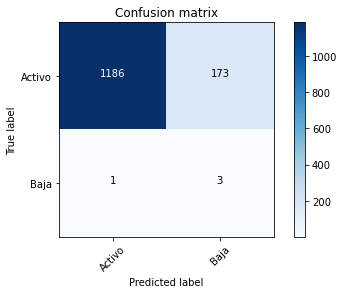

In [27]:
filename = '../mvp_pkl/rfc_model.pkl'
rfc = pickle.load(open(filename, 'rb'))

y_pred = rfc.predict(X)
print(classification_report(y, y_pred ))

cm = confusion_matrix(y, y_pred)
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')

Regresión Logística:

              precision    recall  f1-score   support

           0       1.00      0.56      0.71      1359
           1       0.01      1.00      0.01         4

    accuracy                           0.56      1363
   macro avg       0.50      0.78      0.36      1363
weighted avg       1.00      0.56      0.71      1363



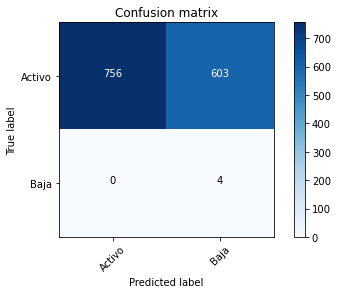

In [28]:
filename = '../mvp_pkl/LR_model.pkl'
LR = pickle.load(open(filename, 'rb'))

y_pred = LR.predict(X)
print(classification_report(y, y_pred ))

cm = confusion_matrix(y, y_pred)
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')

Decission Tree Classifier:

              precision    recall  f1-score   support

           0       1.00      0.69      0.82      1359
           1       0.01      0.75      0.01         4

    accuracy                           0.69      1363
   macro avg       0.50      0.72      0.42      1363
weighted avg       1.00      0.69      0.82      1363



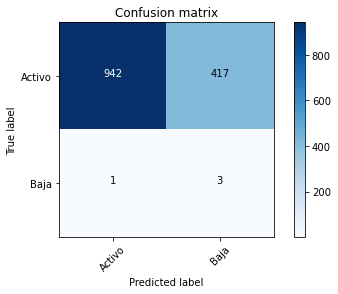

In [29]:
filename = '../mvp_pkl/DT_model.pkl'
DT = pickle.load(open(filename, 'rb'))

y_pred = DT.predict(X)
print(classification_report(y, y_pred ))

cm = confusion_matrix(y, y_pred)
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')

Voting Classifier:

              precision    recall  f1-score   support

           0       1.00      0.74      0.85      1359
           1       0.01      1.00      0.02         4

    accuracy                           0.74      1363
   macro avg       0.51      0.87      0.44      1363
weighted avg       1.00      0.74      0.85      1363



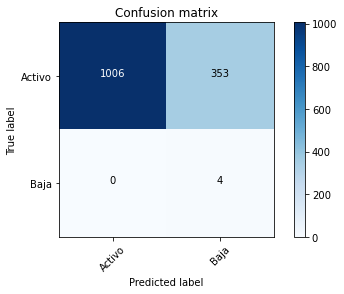

In [30]:
filename = '../mvp_pkl/voting_clf_model.pkl'
voting_clf = pickle.load(open(filename, 'rb'))

y_pred = voting_clf.predict(X)
print(classification_report(y, y_pred ))

cm = confusion_matrix(y, y_pred)
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')

#### Exportar resultados

In [31]:
result_rfc = rfc.predict_proba(X)[:,1].reshape(-1, 1)
result_LR = LR.predict_proba(X)[:,1].reshape(-1, 1)
result_DT = DT.predict_proba(X)[:,1].reshape(-1, 1)
result_VC = voting_clf.predict_proba(X)[:,1].reshape(-1, 1)

In [32]:
df_rfc = pd.DataFrame(result_rfc, columns = ['Random Forest'])
df_LR = pd.DataFrame(result_LR, columns = ['Logistic Regression'])
df_DT = pd.DataFrame(result_DT, columns = ['Decission Tree'])
df_VC = pd.DataFrame(result_VC, columns = ['Voting Classifier'])

In [33]:
result = pd.concat([data_to_result, df_rfc, df_LR, df_DT, df_VC], axis = 1)
result.head()

,Start Date,Cliente,Client Type,Modelo,Provincia,Gender,Nationality,Born Date,Housing Type,Labor Situation,Marital Status,Income Amount,Number Pay,Status Date,Status,Property Type,Financiado,Rango Precio,Resumen Precio,Precio Contado,Precio Total,Precio Mensualidad,Quejas,Incidencias,Edad,Rango_Edad,Income,Dias_Activo,Random Forest,Logistic Regression,Decission Tree,Voting Classifier
0,2021-02-02,550001,Normal,V2,Valencia,HOMBRE,ES - ESPAÑOLA,1974-01-29,3 - ALQUILER,04 AUTONOMO,2 - CASADO,1400,14,2021-02-02,0,Tienda,Financiado,Entre 000-050,49+(48*10),49,529,10,0,0,47.249315,40-50,1000-1500,75,0.383415,0.855058,0.589752,0.603723
1,2021-02-02,550018,Normal,V2,Valencia,HOMBRE,ES - ESPAÑOLA,1950-04-03,1 - PROPIEDAD SIN HIPOTECA,07 PENSIONISTA (JUBILACION),2 - CASADO,1000,12,2021-02-02,0,"Chalet, villa",Financiado,Entre 000-050,49+(36*10),49,409,10,0,0,71.090411,70-80,0-1000,75,0.272919,0.389649,0.509893,0.391920
2,2021-02-02,550020,Normal,V1,Alicante,MUJER,UE - UNION EUROPEA,1933-06-18,1 - PROPIEDAD SIN HIPOTECA,07 PENSIONISTA (JUBILACION),3 - VIUDO,1000,12,2021-02-02,0,Chalet adosado,Financiado,Entre 200-300,299+(36*10),299,659,10,0,0,87.893151,+80,0-1000,75,0.066205,0.242820,0.231153,0.181613
3,2021-02-02,550026,Normal,V2,Valencia,HOMBRE,ES - ESPAÑOLA,1961-03-28,1 - PROPIEDAD SIN HIPOTECA,01 ASALARIADO FIJO,2 - CASADO,1500,14,2021-02-02,0,Apartamento,Financiado,Entre 100-200,199+(36*10),199,559,10,0,0,60.098630,60-70,1000-1500,75,0.054603,0.256827,0.231153,0.179562
4,2021-02-02,550029,Normal,V2,Alicante,HOMBRE,ES - ESPAÑOLA,1988-08-28,1 - PROPIEDAD SIN HIPOTECA,01 ASALARIADO FIJO,1 - SOLTERO,1300,14,2021-02-03,0,Apartamento,Financiado,Entre 000-050,49+(36*10),49,409,10,0,0,32.660274,30-40,1000-1500,75,0.347991,0.637144,0.566871,0.517998


In [34]:
result.to_excel('../data/result_test_mvp.xlsx', index=False)